In [1]:
from cortexlib.utils.file import read_json_file_as_dataframe

# For each layer, results has an FEV score for predicting neural data from SimCLR features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
results = read_json_file_as_dataframe('../regressions/results/simclr_feats_pcs_to_neural_data.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
37,fc,10.0,0.017885,0.112693
2,layer1,20.0,0.026780,0.127222
9,layer2,NaN,0.030758,0.177962
26,layer3,500.0,0.035916,0.157459
27,layer4,NaN,0.022729,0.112540


In [2]:
from cortexlib.stl10 import STL10FewShotDataset

stl10 = STL10FewShotDataset(n_per_class=100, image_size=96)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from cortexlib.simclr import PreTrainedSimCLRModel

simclr = PreTrainedSimCLRModel()
simclr_feats, labels = simclr.extract_features(stl10.dataset)

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
from cortexlib.tsne import TSNEVisualizer
import pandas as pd

# Map each label to its corresponding class name
class_labels = [stl10.class_names[label] for label in labels]

tsne_visualiser = TSNEVisualizer()
tsne_feats = tsne_visualiser.compute_tsne(simclr_feats)
silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, class_labels)
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['layer', 'silhouette'])
silhouette_df

,layer,silhouette
0,layer1,-0.106821
1,layer2,-0.096269
2,layer3,-0.009448
3,layer4,0.075086
4,fc,0.082013


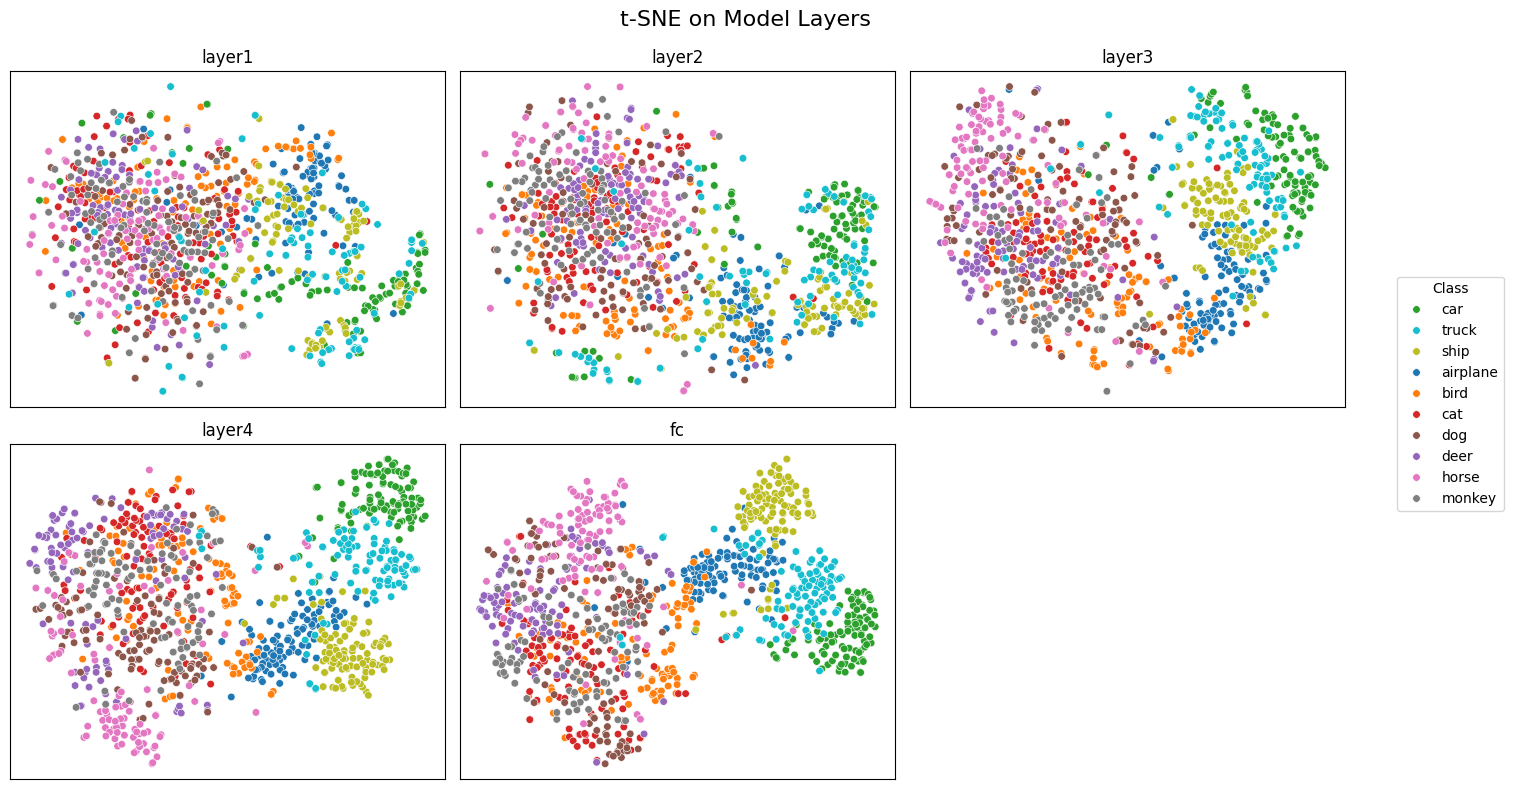

In [5]:
ordered_class_names = ['car', 'truck', 'ship', 'airplane', 'bird', 'cat',
                       'dog', 'deer', 'horse', 'monkey']

tsne_visualiser.plot_clusters_all_layers(tsne_feats, class_labels, custom_legend_order=ordered_class_names)

In [6]:
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['layer', 'silhouette'])
silhouette_df

,layer,silhouette
0,layer1,-0.106821
1,layer2,-0.096269
2,layer3,-0.009448
3,layer4,0.075086
4,fc,0.082013


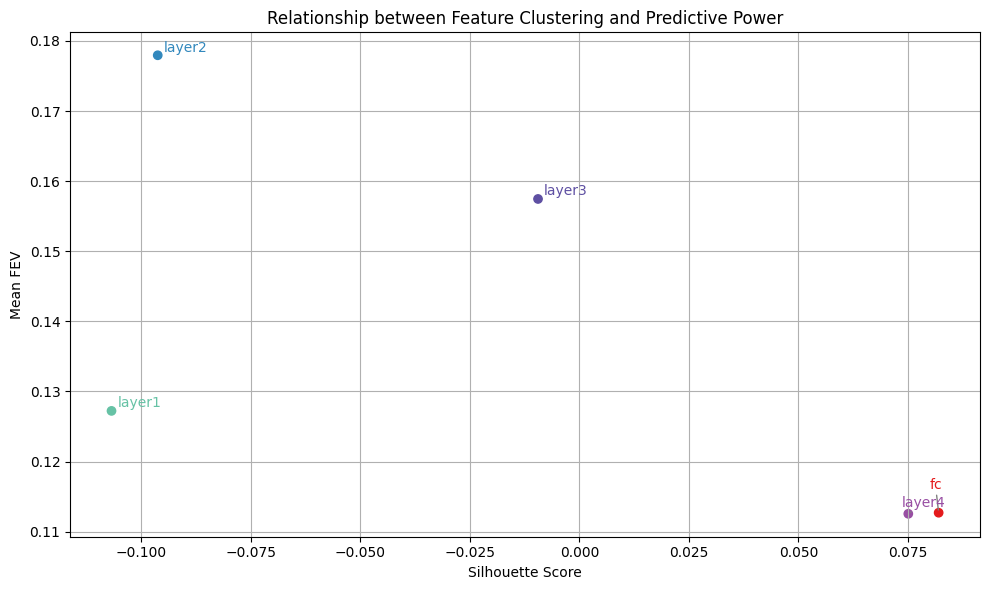

In [12]:
import matplotlib.pyplot as plt
from cortexlib.utils.plotting import simclr_colours
from adjustText import adjust_text

silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['layer', 'silhouette'])
merged_results = pd.merge(best_fev_per_layer, silhouette_df, on='layer')

colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['silhouette'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['silhouette'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Silhouette Score')
plt.ylabel('Mean FEV')
plt.title('Relationship between Feature Clustering and Predictive Power')
plt.grid(True)
plt.tight_layout()
plt.show()
